<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/f-predictDiagrama/ClassificadorXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais


<center>
<table><tr><td> <a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td><a href="https://pyfts.github.io/pyFTS/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/logo_medium.png" alt="pyFTS - Fuzzy Time Series for Python" width="100"/></a></td>
</tr>
</table>
</center>

In [236]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS
#!pip3 install -U pyFTS
!pip3 install SimpSOM
!pip install dispy
#!pip install matplotlib==3.1.3
!pip install matplotlib==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-gsaesqca
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-gsaesqca
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.1-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
simpsom 2.0.1 requires matplotlib>=3.3.3, but you have matplotlib 3.1.1 which is incompatible.


In [237]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

In [238]:
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets = {}

dff = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/DadosFalha.xlsx')
dfn = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/DadosNormais.xlsx')

dados_treino_Falha = dff[0:2300] 
dados_teste_Falha = dff[1800:2300]

dados_treino_Normal = dfn[0:1800] 
dados_teste_Normal = dfn[1500:1800]

In [239]:
print(dados_treino_Falha)

                    Data  LIT_2012KS_0251_FilteredSignal  \
0    2021-12-05 08:50:13                       35.298019   
1    2021-12-05 08:51:25                       69.698112   
2    2021-12-05 08:52:37                       86.492775   
3    2021-12-05 08:53:49                       87.605766   
4    2021-12-05 08:55:01                       87.592270   
...                  ...                             ...   
2295 2021-12-09 22:55:01                       39.161282   
2296 2021-12-09 22:56:13                       34.402630   
2297 2021-12-09 22:57:25                       29.267023   
2298 2021-12-09 22:58:37                       24.829168   
2299 2021-12-09 22:59:49                       18.879450   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
0                        0.000000                604.000305   
1                        0.000000                594.372681   
2                        0.000000                548.985413   
3                        0.

In [240]:
print(dados_treino_Normal)

                    Data  LIT_2012KS_0251_FilteredSignal  \
0    2021-12-05 07:20:13                        2.832069   
1    2021-12-05 07:21:25                        4.418116   
2    2021-12-05 07:22:37                       22.953905   
3    2021-12-05 07:23:49                       33.815975   
4    2021-12-05 07:25:01                       33.374435   
...                  ...                             ...   
1795 2021-12-07 02:38:13                       11.774282   
1796 2021-12-07 02:39:25                        4.781181   
1797 2021-12-07 02:40:37                        3.563411   
1798 2021-12-07 02:41:49                        3.671766   
1799 2021-12-07 02:43:01                        3.691521   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
0                        0.000000                295.496826   
1                        0.000000                321.693665   
2                       14.761859                337.279755   
3                       71.

In [241]:
print(dados_teste_Falha)

                    Data  LIT_2012KS_0251_FilteredSignal  \
1800 2021-12-08 22:32:13                       68.584373   
1801 2021-12-08 22:33:25                       79.267204   
1802 2021-12-08 22:34:37                       74.231430   
1803 2021-12-08 22:35:49                       67.143143   
1804 2021-12-08 22:37:01                       56.879524   
...                  ...                             ...   
2295 2021-12-09 22:55:01                       39.161282   
2296 2021-12-09 22:56:13                       34.402630   
2297 2021-12-09 22:57:25                       29.267023   
2298 2021-12-09 22:58:37                       24.829168   
2299 2021-12-09 22:59:49                       18.879450   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
1800                    36.922737                551.704773   
1801                    51.525627                551.704529   
1802                    59.430199                551.716675   
1803                    59.

In [242]:
print(dados_teste_Normal)

                    Data  LIT_2012KS_0251_FilteredSignal  \
1500 2021-12-08 09:28:37                       43.040955   
1501 2021-12-08 09:29:49                       37.851479   
1502 2021-12-08 09:31:01                       32.487022   
1503 2021-12-08 09:32:13                       27.220686   
1504 2021-12-08 09:33:25                       22.106337   
...                  ...                             ...   
1795 2021-12-07 02:38:13                       11.774282   
1796 2021-12-07 02:39:25                        4.781181   
1797 2021-12-07 02:40:37                        3.563411   
1798 2021-12-07 02:41:49                        3.671766   
1799 2021-12-07 02:43:01                        3.691521   

      _AL_2012KS_06M1_SpeedActual  WIT_1085KS_2300_BeltLoad  \
1500                    59.528919                297.226349   
1501                    59.413948                246.993668   
1502                    59.192154                220.550995   
1503                    59.

## Analisando as Séries Temporais

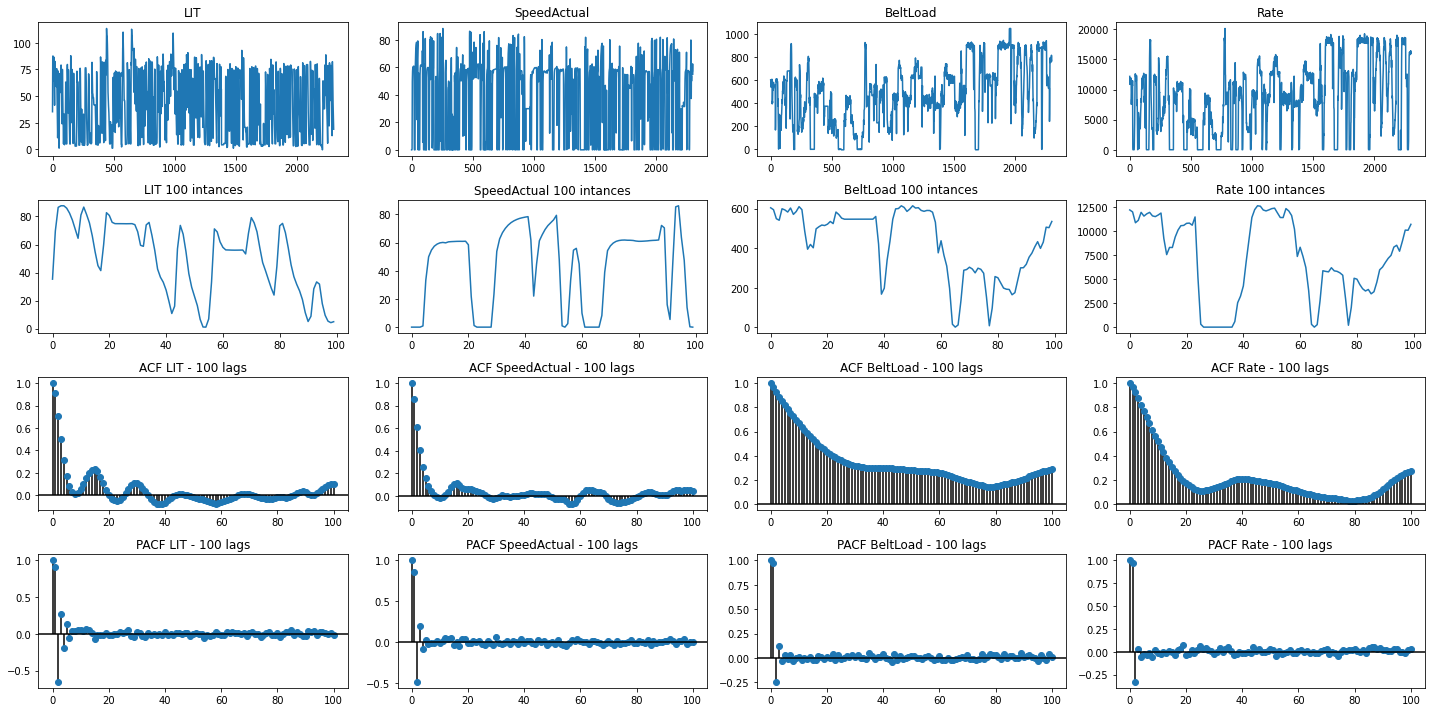

In [243]:
#Dados com Falhas

from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets1 = {}

datasets1['LIT'] = dados_treino_Falha.get('LIT_2012KS_0251_FilteredSignal')
datasets1['SpeedActual'] = dados_treino_Falha.get('_AL_2012KS_06M1_SpeedActual')
datasets1['BeltLoad'] = dados_treino_Falha.get('WIT_1085KS_2300_BeltLoad')
datasets1['Rate'] = dados_treino_Falha.get('WIT_1085KS_2300_Rate')


fig1, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets1.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

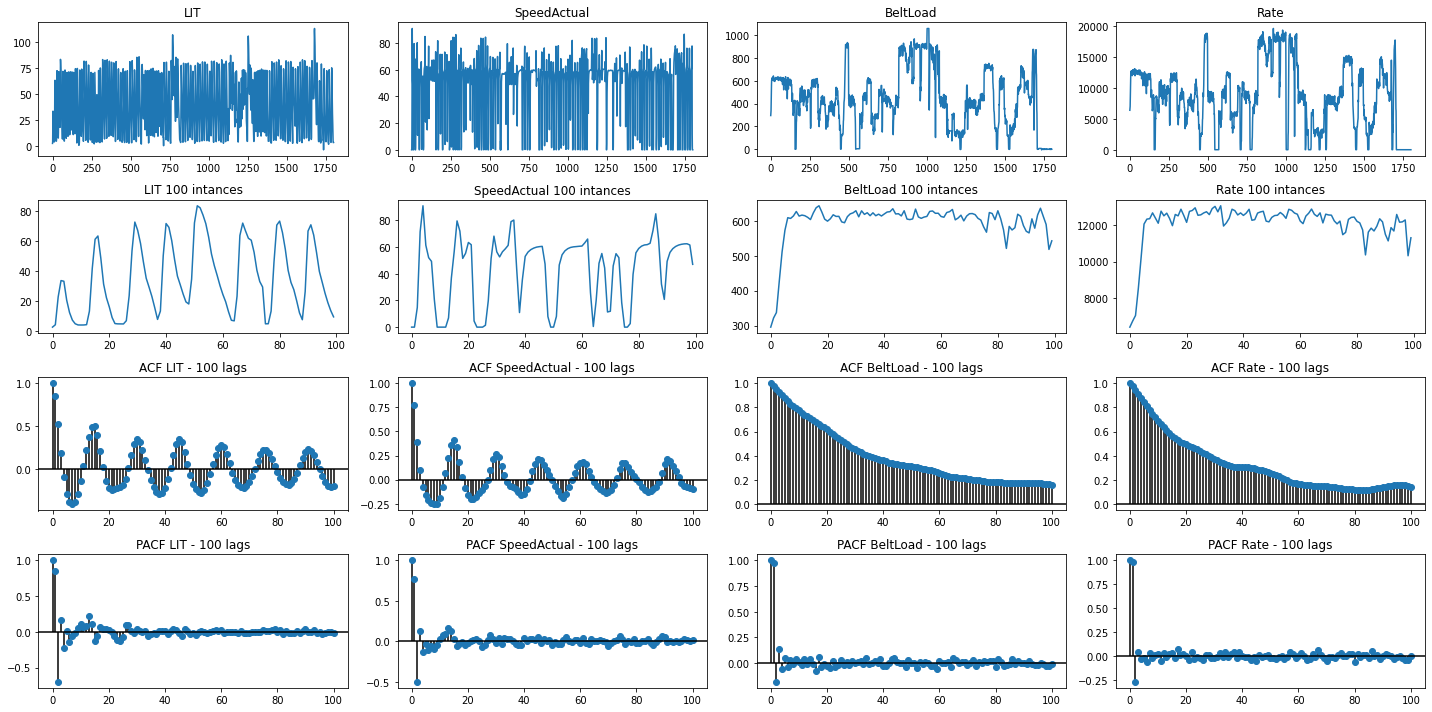

In [244]:
#Dados normais - sem falhas
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets2 = {}

datasets2['LIT'] = dados_treino_Normal.get('LIT_2012KS_0251_FilteredSignal')
datasets2['SpeedActual'] = dados_treino_Normal.get('_AL_2012KS_06M1_SpeedActual')
datasets2['BeltLoad'] = dados_treino_Normal.get('WIT_1085KS_2300_BeltLoad')
datasets2['Rate'] = dados_treino_Normal.get('WIT_1085KS_2300_Rate')


fig2, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets2.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

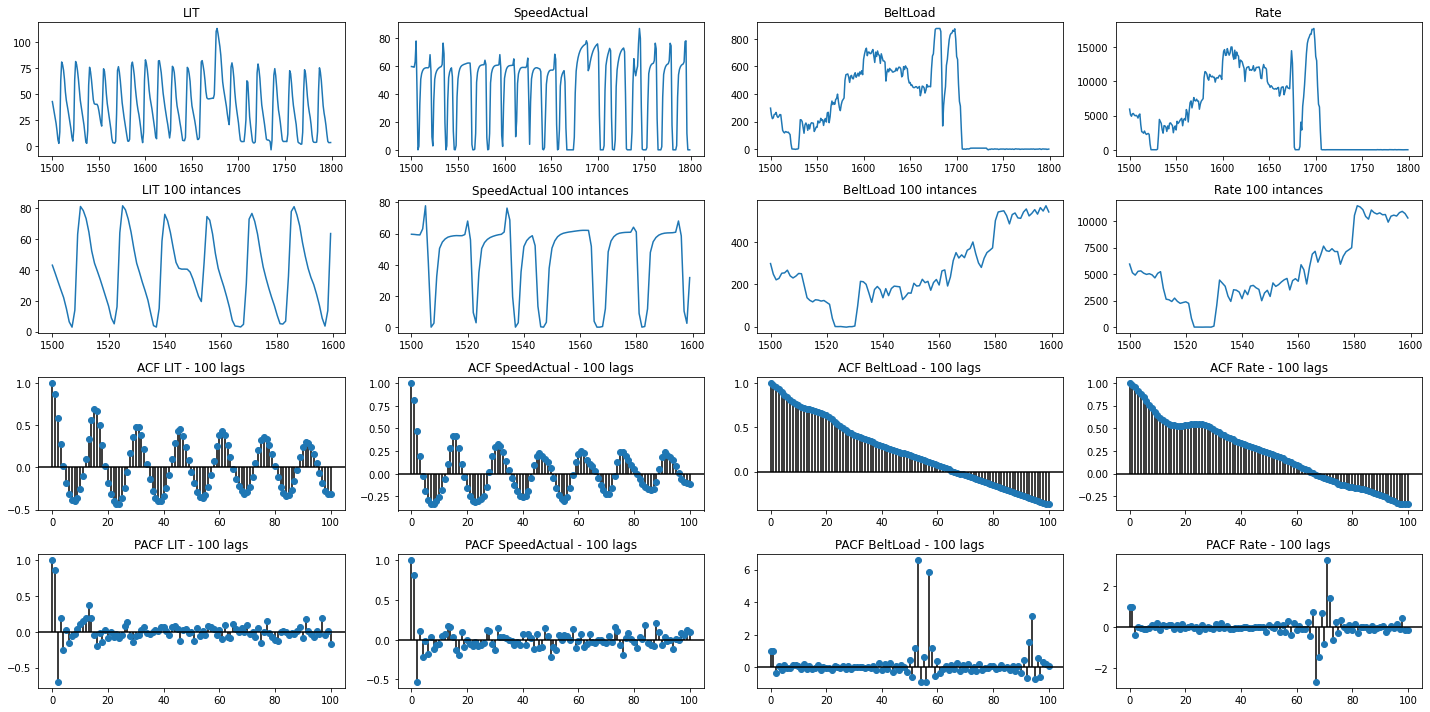

In [245]:
#Dados normais - sem falhas
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets3 = {}

datasets3['LIT'] = dados_teste_Normal.get('LIT_2012KS_0251_FilteredSignal')
datasets3['SpeedActual'] = dados_teste_Normal.get('_AL_2012KS_06M1_SpeedActual')
datasets3['BeltLoad'] = dados_teste_Normal.get('WIT_1085KS_2300_BeltLoad')
datasets3['Rate'] = dados_teste_Normal.get('WIT_1085KS_2300_Rate')


fig3, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets3.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

,Partitions,RMSE,MAPE,U
0,Grid,12.28,117.88,1.04


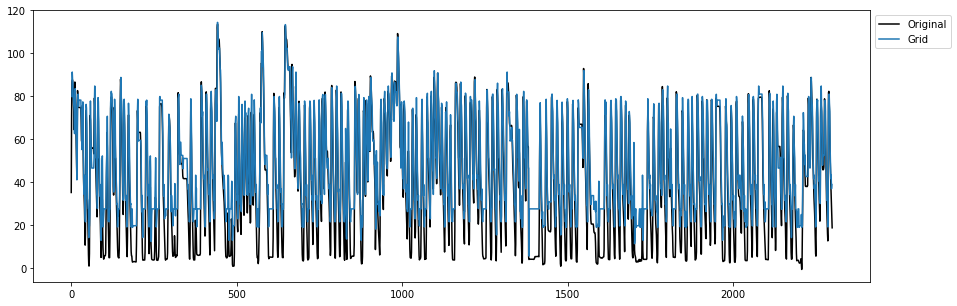

In [246]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy
from pyFTS.benchmarks import Measures

metodos = [Grid.GridPartitioner]#, Entropy.EntropyPartitioner, CMeans.CMeansPartitioner ]

k = 30

rows = []

y1=np.asarray(datasets1['LIT'])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y1, label='Original',color='black')

for contador, metodo in enumerate(metodos):
  part = metodo(data=y1, npart=k)
  model = hofts.HighOrderFTS(order=2, partitioner=part)
  model.fit(y1)
  forecasts = model.predict(y1)
  for o in range(model.order):
    forecasts.insert(0,None)
    
  ax.plot(forecasts[:-1], label=part.name)
  
  rmse, mape, u = Measures.get_point_statistics(y1, model)
  
  rows.append([part.name, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

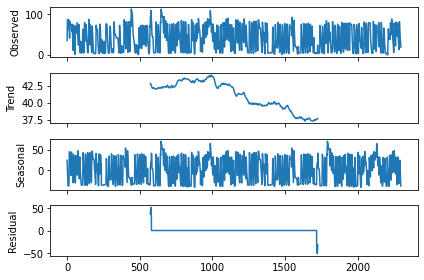

In [247]:
from statsmodels.tsa.seasonal import seasonal_decompose
#for i in range(500):
result = seasonal_decompose(datasets1['LIT'],model='aditive',freq=1146)
tmp = result.plot()
#  print(i)

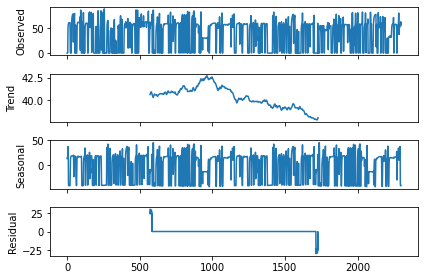

In [248]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(datasets1['SpeedActual'],model='aditive',freq=1143)

tmp = result.plot()


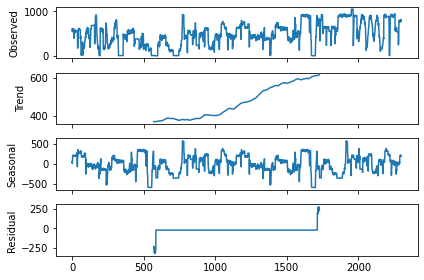

In [249]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(datasets1['BeltLoad'],model='aditive',freq=1143)

tmp = result.plot()

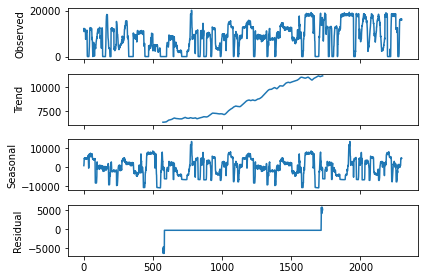

In [250]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(datasets1['Rate'],model='aditive',freq=1145)

tmp = result.plot()

### Teste de Estacionariedade - ADF

*   Item da lista
*   Item da lista



O Teste de Dickey-Fuller Aumentado (ADF) testa, para um processo estocástico P modelado por uma equação autoregressiva AR(p), se as raízes desse modelo são unitárias. Se forem P é não-estacionário, do contrário estacionário. As hipóteses de teste são:

* $H_0$: O processo possui raiz unitária, logo é **não-estacionário**.
* $H_1$: O processo não possui raiz unitária, logo é **estacionário**.

A estatística de teste ADF ao nível de significância $\alpha$ é um número negativo e, quanto mais negativo e distante dos valores críticos, maior a evidência contrária à $H_0$. 

A estatística ADF também pode ser convertida em um p-valor da distribuição de teste e se o valor-p for maior do que $\alpha$, então aceitamos $H_0$ ao nível de significância $\alpha$ de que o processo é não estacionário. Do contrário, dizemos que não há evidências para aceitar $H_0$ então o processo é estacionário.

In [251]:
from statsmodels.tsa.stattools import adfuller

def ADF(X):
  print("\n\t---------------------------------------------------------")
  print("\tTeste de Estacionariedade - Dickey-Fuller Aumentado (ADF)")
  print("\t---------------------------------------------------------")
  print("H0: O processo é não-estacionário.")
  print("H1: O processo é estacionário.")
  result = adfuller(X)
  print('\nEstatística ADF: {}'.format(result[0]))
  print('p-Valor: {}'.format(result[1]))
  print('Valores Críticos:')
  print('\tAlfa\tVal. Crit\tResultado')
  for key, value in result[4].items():
    h0 = "H0 Aceita - Não estacionário" if result[0] > value else "H0 Rejeitada - Estacionário"
    print('\t{}\t{}\t{}'.format(key, value, h0))

In [252]:
ADF(datasets1['LIT'])


	---------------------------------------------------------
	Teste de Estacionariedade - Dickey-Fuller Aumentado (ADF)
	---------------------------------------------------------
H0: O processo é não-estacionário.
H1: O processo é estacionário.

Estatística ADF: -8.884188106607837
p-Valor: 1.2935229485681944e-14
Valores Críticos:
	Alfa	Val. Crit	Resultado
	1%	-3.433215059686721	H0 Rejeitada - Estacionário
	5%	-2.862805715808642	H0 Rejeitada - Estacionário
	10%	-2.5674437983902245	H0 Rejeitada - Estacionário


In [253]:
ADF(datasets1['SpeedActual'])


	---------------------------------------------------------
	Teste de Estacionariedade - Dickey-Fuller Aumentado (ADF)
	---------------------------------------------------------
H0: O processo é não-estacionário.
H1: O processo é estacionário.

Estatística ADF: -8.53769260341927
p-Valor: 9.976459466962846e-14
Valores Críticos:
	Alfa	Val. Crit	Resultado
	1%	-3.4332200895747174	H0 Rejeitada - Estacionário
	5%	-2.862807936825532	H0 Rejeitada - Estacionário
	10%	-2.5674449809195186	H0 Rejeitada - Estacionário


In [254]:
ADF(datasets1['BeltLoad'])


	---------------------------------------------------------
	Teste de Estacionariedade - Dickey-Fuller Aumentado (ADF)
	---------------------------------------------------------
H0: O processo é não-estacionário.
H1: O processo é estacionário.

Estatística ADF: -6.39627014107875
p-Valor: 2.047178629609069e-08
Valores Críticos:
	Alfa	Val. Crit	Resultado
	1%	-3.433202561761398	H0 Rejeitada - Estacionário
	5%	-2.8628001971599955	H0 Rejeitada - Estacionário
	10%	-2.5674408601155303	H0 Rejeitada - Estacionário


In [255]:
ADF(datasets1['Rate'])


	---------------------------------------------------------
	Teste de Estacionariedade - Dickey-Fuller Aumentado (ADF)
	---------------------------------------------------------
H0: O processo é não-estacionário.
H1: O processo é estacionário.

Estatística ADF: -5.6895151849308805
p-Valor: 8.132141339173095e-07
Valores Críticos:
	Alfa	Val. Crit	Resultado
	1%	-3.4332302025201686	H0 Rejeitada - Estacionário
	5%	-2.8628124023257175	H0 Rejeitada - Estacionário
	10%	-2.567447358474132	H0 Rejeitada - Estacionário


### Teste de Homocedasticidade - Levene

O teste de Levene compara a variância de vários conjuntos de dados e verifica que elas são significativamente diferentes. No caso de processos estocásticos, deve-se dividir o processo em sub-amostras de igual tamanho e executar o teste para verificar a igualdade das médias entre os sub-amostras. 

As hipóteses do teste são:

$H_0$: As variâncias das sub-amostras são iguais, indicando **homocedasticidade**.

$H_1$: Ao menos uma das sub-amostras tem variância diferente das demais, indicando **heterocedasticidade**.

In [256]:
from scipy.stats import levene

def Levene(X):
  print("\n\t---------------------------------------------------------")
  print("\tTeste de Homocedasticidade - Levene")
  print("\t---------------------------------------------------------")
  print("H0: As variâncias das sub-amostras são iguais, a série é homocedástica.")
  print("H1: As variâncias das sub-amostras são diferentes, a série é heterocedástica")
  janelas = np.array_split(X, 30)
  resultado = levene(*janelas)
  print("\nEstatística de teste: {}".format(resultado.statistic))
  print("p-Valor: {}".format(resultado.pvalue))
  print("Resultado: {}".format('H0 Aceita - homocedástica' if resultado.pvalue > 0.05 else 'H0 Rejeitada - heterocedástica'))

In [257]:
Levene(datasets3['LIT'])


	---------------------------------------------------------
	Teste de Homocedasticidade - Levene
	---------------------------------------------------------
H0: As variâncias das sub-amostras são iguais, a série é homocedástica.
H1: As variâncias das sub-amostras são diferentes, a série é heterocedástica

Estatística de teste: 1.597323644086727
p-Valor: 0.03048265367355352
Resultado: H0 Rejeitada - heterocedástica


In [258]:
Levene(datasets3['SpeedActual'])


	---------------------------------------------------------
	Teste de Homocedasticidade - Levene
	---------------------------------------------------------
H0: As variâncias das sub-amostras são iguais, a série é homocedástica.
H1: As variâncias das sub-amostras são diferentes, a série é heterocedástica

Estatística de teste: 3.3577244953537293
p-Valor: 9.890069407148121e-08
Resultado: H0 Rejeitada - heterocedástica


In [259]:
Levene(datasets3['BeltLoad'])


	---------------------------------------------------------
	Teste de Homocedasticidade - Levene
	---------------------------------------------------------
H0: As variâncias das sub-amostras são iguais, a série é homocedástica.
H1: As variâncias das sub-amostras são diferentes, a série é heterocedástica

Estatística de teste: 18.946639527524205
p-Valor: 1.9366696043295423e-49
Resultado: H0 Rejeitada - heterocedástica


In [260]:
Levene(datasets3['Rate'])


	---------------------------------------------------------
	Teste de Homocedasticidade - Levene
	---------------------------------------------------------
H0: As variâncias das sub-amostras são iguais, a série é homocedástica.
H1: As variâncias das sub-amostras são diferentes, a série é heterocedástica

Estatística de teste: 13.35608484267338
p-Valor: 2.911745172666609e-37
Resultado: H0 Rejeitada - heterocedástica


### Teste de Ljung-Box

O Teste de Ljung-Box teste se uma autocorrelação $\rho(k)$, para um lag $k$, é significativamente diferente de zero ou se o valor da autocorrelação $\rho(k)$ é fruto de uma flutuação aleatória.

As hipóteses do teste são, para cada lag $k$:

$H_0$: $\rho(k)$ não é significativamente diferente de zero, indicando que **não há autocorrelação**.

$H_1$: $\rho(k)$ é significativamente diferente de zero, indicando que **há autocorrelação**.

In [261]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def LjungBox(X, lags=12):
  print("\n\t---------------------------------------------------------")
  print("\tTeste de Autocorrelação - Ljung-Box")
  print("\t---------------------------------------------------------")
  print("H0: O lag não tem autocorrelação (é IID).")
  print("H1: O lag tem autocorrelação.")
  lj, pval = acorr_ljungbox(X, lags=lags)
  for i in range(len(lj)):
    print("LAG {}".format(i+1))
    print("\tEstatística de teste: {}".format(lj[i]))
    print("\tp-Valor: {}".format(pval[i]))
    print("\tResultado: {}".format('H0 Aceita' if pval[i] > 0.05 else 'H0 Rejeitada - Lag RELEVANTE'))


LjungBox(datasets3['LIT'], lags=24)


	---------------------------------------------------------
	Teste de Autocorrelação - Ljung-Box
	---------------------------------------------------------
H0: O lag não tem autocorrelação (é IID).
H1: O lag tem autocorrelação.
LAG 1
	Estatística de teste: 227.64469445825162
	p-Valor: 1.945390154689175e-51
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 2
	Estatística de teste: 330.7445469214134
	p-Valor: 1.5126351084959646e-72
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 3
	Estatística de teste: 354.8100041935395
	p-Valor: 1.3556369693650971e-76
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 4
	Estatística de teste: 354.9179176666157
	p-Valor: 1.52086886541262e-75
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 5
	Estatística de teste: 364.8026392257165
	p-Valor: 1.1365425980935177e-76
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 6
	Estatística de teste: 394.3269178801078
	p-Valor: 4.634746248710028e-82
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 7
	Estatística de teste: 439.38481369980656
	

In [262]:
LjungBox(datasets3['SpeedActual'], lags=24)


	---------------------------------------------------------
	Teste de Autocorrelação - Ljung-Box
	---------------------------------------------------------
H0: O lag não tem autocorrelação (é IID).
H1: O lag tem autocorrelação.
LAG 1
	Estatística de teste: 198.66024906735944
	p-Valor: 4.0944949174692466e-45
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 2
	Estatística de teste: 267.8748004678155
	p-Valor: 6.787754994066255e-59
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 3
	Estatística de teste: 279.21419128741843
	p-Valor: 3.1323095803127244e-60
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 4
	Estatística de teste: 279.4694365838128
	p-Valor: 2.899907623307122e-59
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 5
	Estatística de teste: 289.9577826501733
	p-Valor: 1.44302555410277e-60
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 6
	Estatística de teste: 316.2734673567217
	p-Valor: 2.658380913081522e-65
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 7
	Estatística de teste: 351.54811026881833
	

In [263]:
LjungBox(datasets3['BeltLoad'], lags=24)


	---------------------------------------------------------
	Teste de Autocorrelação - Ljung-Box
	---------------------------------------------------------
H0: O lag não tem autocorrelação (é IID).
H1: O lag tem autocorrelação.
LAG 1
	Estatística de teste: 292.8317225733892
	p-Valor: 1.2010462961872773e-65
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 2
	Estatística de teste: 571.5103624391614
	p-Valor: 7.908636614614225e-125
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 3
	Estatística de teste: 835.6530242030124
	p-Valor: 8.011673359837438e-181
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 4
	Estatística de teste: 1083.6096476878483
	p-Valor: 2.702703689809715e-233
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 5
	Estatística de teste: 1316.1539081114645
	p-Valor: 2.021056942592352e-282
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 6
	Estatística de teste: 1534.2061845344676
	p-Valor: 0.0
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 7
	Estatística de teste: 1737.8289283975041
	p-Valor: 0.0


In [264]:
LjungBox(datasets3['Rate'], lags=24)


	---------------------------------------------------------
	Teste de Autocorrelação - Ljung-Box
	---------------------------------------------------------
H0: O lag não tem autocorrelação (é IID).
H1: O lag tem autocorrelação.
LAG 1
	Estatística de teste: 291.830648432125
	p-Valor: 1.984626767211579e-65
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 2
	Estatística de teste: 566.9875181089154
	p-Valor: 7.58970312596495e-124
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 3
	Estatística de teste: 823.903574827453
	p-Valor: 2.831498480482635e-178
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 4
	Estatística de teste: 1062.3287888093432
	p-Valor: 1.1073383485613158e-228
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 5
	Estatística de teste: 1281.9178818165583
	p-Valor: 5.2807293576513295e-275
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 6
	Estatística de teste: 1481.7879520345634
	p-Valor: 0.0
	Resultado: H0 Rejeitada - Lag RELEVANTE
LAG 7
	Estatística de teste: 1661.5206024689876
	p-Valor: 0.0
	R

###Análise de CCF

In [265]:
#from nsepy import get_history
import datetime
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from nsepy.derivatives import get_expiry_date

In [266]:
def Var(X):
  n = len(X)
  mx = np.mean(X)
  c = np.mean([(x - mx)**2 for x in X])
  return c

def AutoCov(X, k):
  n = len(X)
  mx = np.mean(X)
  c = np.zeros(n-k)
  for i in range(n - k):
    c[i] = (X[i] - mx)*(X[i+k] - mx)
  c = c.mean()
  
  return c

def CrossCov(X, Y, k):
  n = len(X)
  mx = np.mean(X)
  my = np.mean(Y)
  c = np.zeros(n-k)
  for i in range(n - k):
    c[i] = (X[i] - mx)*(Y[i+k] - my)
  c = c.mean()
  
  return c

def ACF(X, k):
  gamma_k = AutoCov(X, k)
  gamma_0 = Var(X)
  return gamma_k / gamma_0

def CCF(X, Y, k):
  gamma_xy = CrossCov(X, Y, k)
  gamma_x = Var(X)
  gamma_y = Var(Y)
  return gamma_xy / np.sqrt(gamma_x * gamma_y)

In [267]:
def plot_acf(X, k, **kwargs):
  acf = []
  for i in range(k):
    acf.append(ACF(X, i))

  ax = kwargs.get("axis", None)
  if ax is None:
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[10,5])

  ax.hlines([0],[0],[k], color="black")
  ax.vlines([i for i in range(k)], [0 for i in range(k)], acf, color="red")
  ax.scatter([i for i in range(k)], acf, marker="*")
  ax.set_xlabel("k")
  ax.set_ylabel("ACF(k)")

def plot_ccf(X, Y, k, **kwargs):
  ccf = []
  for i in range(k):
    ccf.append(CCF(X, Y,  i))

  ax = kwargs.get("axis", None)
  if ax is None:
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[10,5])

  ax.hlines([0],[0],[k], color="black")
  ax.vlines([i for i in range(k)], [0 for i in range(k)], ccf, color="red")
  ax.scatter([i for i in range(k)], ccf, marker="*")
  ax.set_xlabel("k")
  ax.set_ylabel("CCF(k)")

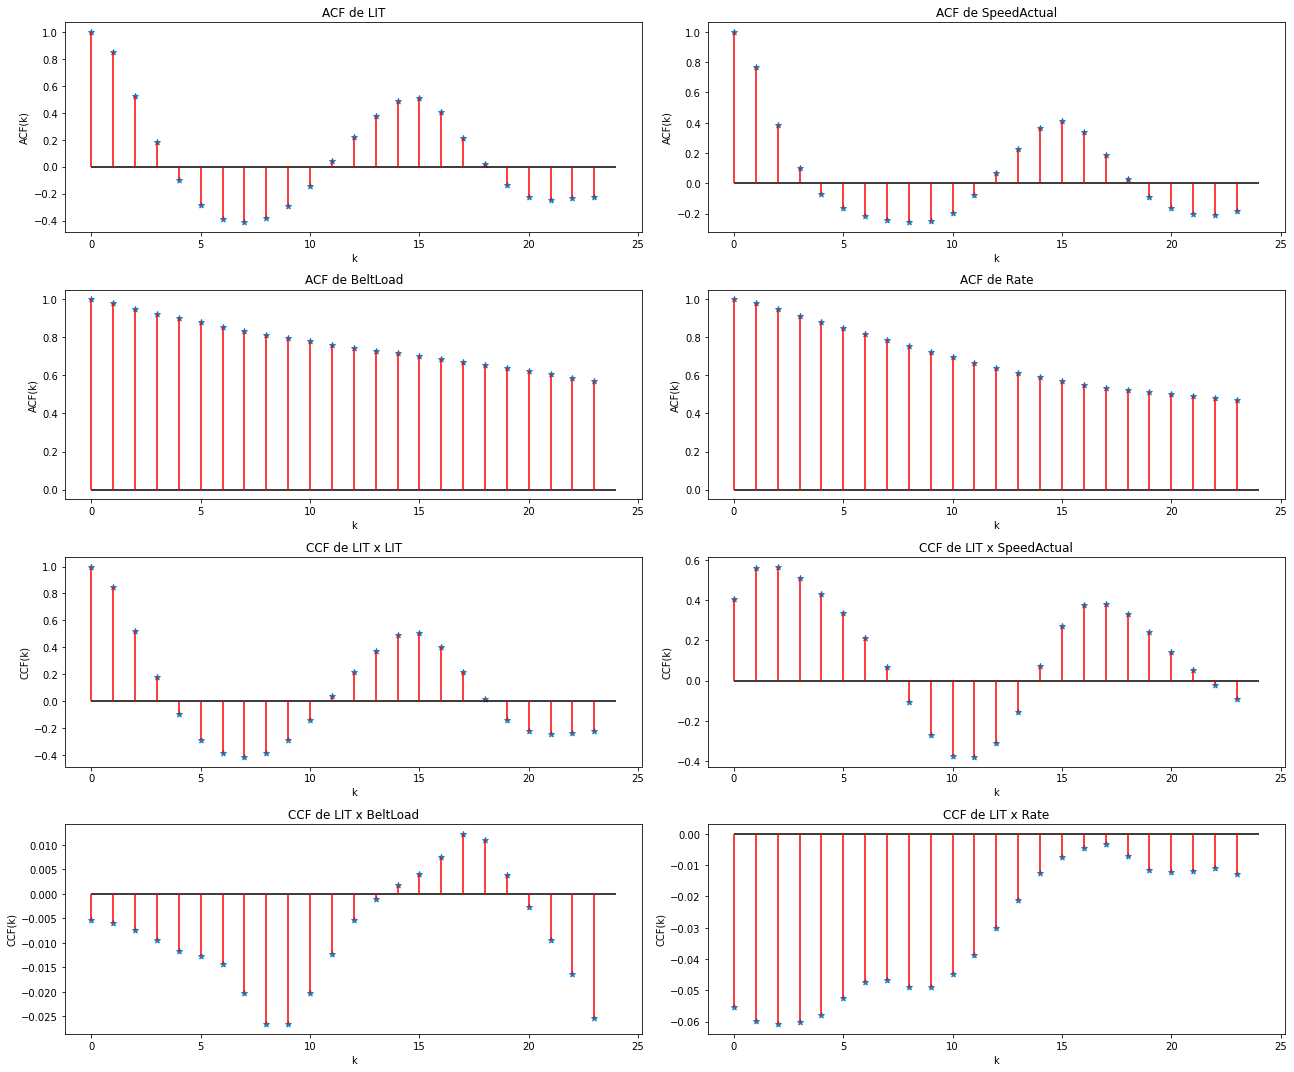

In [268]:
fig, ax = plt.subplots(nrows=4, ncols=2,figsize=[18,15])

ax[0][0].set_title('ACF de LIT')
plot_acf(datasets2['LIT'].values, 24, axis=ax[0][0])
ax[0][1].set_title('ACF de SpeedActual')
plot_acf(datasets2['SpeedActual'].values, 24, axis=ax[0][1])
ax[1][0].set_title('ACF de BeltLoad')
plot_acf(datasets2['BeltLoad'].values, 24, axis=ax[1][0])
ax[1][1].set_title('ACF de Rate')
plot_acf(datasets2['Rate'].values, 24, axis=ax[1][1])
ax[2][0].set_title('CCF de LIT x LIT')
plot_ccf(datasets2['LIT'].values, datasets2['LIT'].values, 24, axis=ax[2][0])
ax[2][1].set_title('CCF de LIT x SpeedActual')
plot_ccf(datasets2['LIT'].values, datasets2['SpeedActual'].values, 24, axis=ax[2][1])
ax[3][0].set_title('CCF de LIT x BeltLoad')
plot_ccf(datasets2['LIT'].values, datasets2['BeltLoad'].values, 24, axis=ax[3][0])
ax[3][1].set_title('CCF de LIT x Rate')
plot_ccf(datasets2['LIT'].values, datasets2['Rate'].values, 24, axis=ax[3][1])

plt.tight_layout()

###Classificador

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
[[5.20794937e-01 3.51428679e-01 5.56970061e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.54046046e-01 3.24619755e-01 4.19192769e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.04892244e-01 8.12349134e-02 2.95153727e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 4.42045046e-04 1.98139176e-02 ... 7.39487566e-02
  2.93760453e-01 4.35476043e-01]
 [0.00000000e+00 0.00000000e+00 1.38999388e-04 ... 1.11303577e-01
  1.45131010e-01 4.54841208e-01]
 [1.25927486e-02 1.43671356e-01 1.12357775e-01 ... 8.13692130e-02
  1.12407682e-01 9.46322200e-02]]


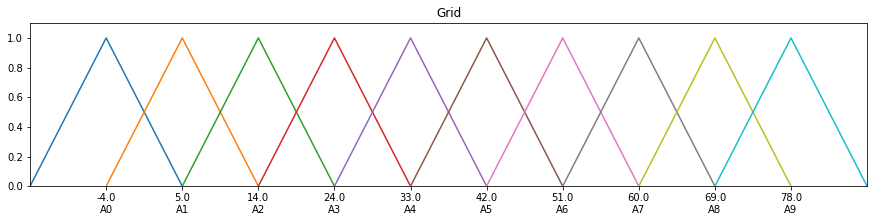

In [269]:
#Dados Sem Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y1 = datasets2['LIT']
tam_grupo = 100
i=0
VT1=[]

for i in range(0,y1.size,tam_grupo):
  grpan = y1[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model1 = metodo(partitioner=part, progress=False, type='distribution')
    if model1.is_high_order:
      model1 = metodo(partitioner=part, order=1)
    model1.fit(np.asarray(y1))  
  #print(model1)
  _, _, lhs1, rhs1 = pwfts.highorder_fuzzy_markov_chain(model1)
  lhs1t = np.transpose(lhs1)
  V1 = np.c_[rhs1,lhs1t]
  if i == 0 :
    VT1 = V1
  else:
    VT1 = np.c_[VT1,V1]

  print(i)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,3])  
part.plot(ax)
VT1 = np.transpose(VT1)
print(VT1)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
[[0.63564032 0.29436782 0.3731472  ... 0.00272307 0.00210211 0.        ]
 [0.15964179 0.05136032 0.04394166 ... 0.01063507 0.0232674  0.        ]
 [0.07223026 0.0372693  0.02773656 ... 0.00872978 0.07065097 0.02979623]
 ...
 [0.         0.00327941 0.00536503 ... 0.12503673 0.31247289 0.18711122]
 [0.         0.         0.         ... 0.0244453  0.10015853 0.21388117]
 [0.11498654 0.03762983 0.02782005 ... 0.14868944 0.04616166 0.01176464]]


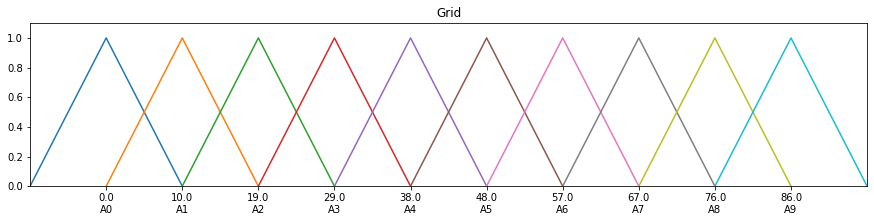

In [270]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y2 = datasets2['SpeedActual']
tam_grupo = 100
i=0
VT2=[]
V2=[]

for i in range(0,y2.size,tam_grupo):
  grpan = y2[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model2 = metodo(partitioner=part, progress=False, type='distribution')
    if model2.is_high_order:
      model2 = metodo(partitioner=part, order=1)
    model2.fit(np.asarray(y2))  
  #print(model1)
  _, _, lhs2, rhs2 = pwfts.highorder_fuzzy_markov_chain(model2)
  lhs2t = np.transpose(lhs2)
  V2 = np.c_[rhs2,lhs2t]
  if i == 0 :
    VT2 = V2
  else:
    VT2 = np.c_[VT2,V2]

  print(i)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,3])  
part.plot(ax)
VT2 = np.transpose(VT2)
print(VT2)



0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
[[9.20681137e-01 2.51696630e-01 5.22246875e-02 ... 5.31317503e-03
  0.00000000e+00 0.00000000e+00]
 [5.78969575e-02 4.26303091e-01 1.88782603e-01 ... 5.84697498e-03
  0.00000000e+00 6.55735826e-04]
 [1.13428586e-02 2.31732341e-01 3.23712512e-01 ... 3.54948115e-03
  6.94309771e-04 2.42658750e-03]
 ...
 [0.00000000e+00 1.10686275e-02 2.52114605e-03 ... 2.06152737e-01
  6.44491068e-01 1.21990924e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.77609124e-02
  1.92837671e-01 8.52151590e-01]
 [8.03893756e-02 1.96368688e-02 7.25096338e-02 ... 8.74179489e-02
  1.24102350e-01 1.89845955e-01]]


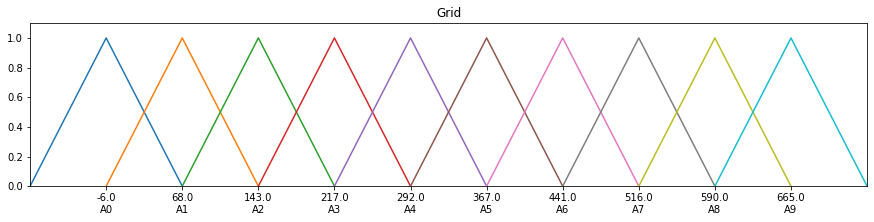

In [271]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y3 = datasets2['BeltLoad']
tam_grupo = 100
i=0
VT3=[]
V3=[]

for i in range(0,y3.size,tam_grupo):
  grpan = y3[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model3 = metodo(partitioner=part, progress=False, type='distribution')
    if model3.is_high_order:
      model3 = metodo(partitioner=part, order=1)
    model3.fit(np.asarray(y3))  
  #print(model1)
  _, _, lhs3, rhs3 = pwfts.highorder_fuzzy_markov_chain(model3)
  lhs3t = np.transpose(lhs3)
  V3 = np.c_[rhs3,lhs3t]
  if i == 0 :
    VT3 = V3
  else:
    VT3 = np.c_[VT3,V3]

  print(i)
  
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,3])  
part.plot(ax)
VT3 = np.transpose(VT3)
print(VT3)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
[[9.33144994e-01 2.56247660e-01 7.65074889e-02 ... 5.98855671e-04
  1.29962181e-03 2.91582981e-03]
 [4.50477132e-02 4.04034550e-01 1.48157460e-01 ... 2.63121732e-03
  1.72389391e-03 0.00000000e+00]
 [1.52275711e-02 2.43140157e-01 3.33306443e-01 ... 3.39476915e-03
  9.47974609e-03 2.57574643e-03]
 ...
 [0.00000000e+00 1.30614977e-03 4.63955056e-04 ... 2.09091982e-01
  6.64805202e-01 1.13634687e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.63968745e-02
  1.68371034e-01 8.61279592e-01]
 [1.24177092e-01 1.96063079e-02 6.70466707e-02 ... 8.28212667e-02
  1.18494108e-01 1.77687454e-01]]


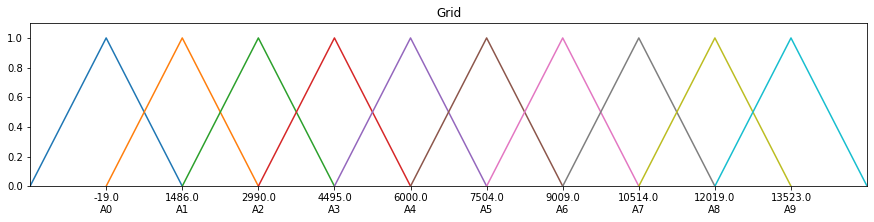

In [272]:
#Dados Sem Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y4 = datasets2['Rate']
tam_grupo = 100
i=0
VT4=[]
V4=[]

for i in range(0,y4.size,tam_grupo):
  grpan = y4[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model4 = metodo(partitioner=part, progress=False, type='distribution')
    if model4.is_high_order:
      model4 = metodo(partitioner=part, order=1)
    model4.fit(np.asarray(y4))  
  #print(model1)
  _, _, lhs4, rhs4 = pwfts.highorder_fuzzy_markov_chain(model4)
  lhs4t = np.transpose(lhs4)
  V4 = np.c_[rhs4,lhs4t]
  if i == 0 :
    VT4 = V4
  else:
    VT4 = np.c_[VT4,V4]

  print(i)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,3])  
part.plot(ax)
VT4 = np.transpose(VT4)
print(VT4)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
[[5.55453502e-01 3.77174079e-01 3.65231193e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.48420113e-01 3.79223123e-01 3.79472690e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.51803956e-02 8.68887655e-02 3.53107324e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 4.98086179e-04 ... 1.40073606e-01
  4.56368345e-01 3.76413338e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.50990407e-02
  7.45288048e-02 5.82065559e-01]
 [9.54333949e-02 1.58784913e-01 9.97401002e-02 ... 1.08798565e-01
  1.08116872e-01 4.32795925e-02]]


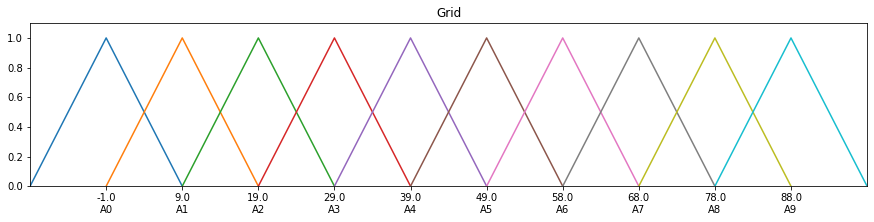

In [273]:
#Dados Com Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y1 = datasets1['LIT']
tam_grupo = 100
i=0
VU1=[]

for i in range(0,y1.size,tam_grupo):
  grpan = y1[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model1 = metodo(partitioner=part, progress=False, type='distribution')
    if model1.is_high_order:
      model1 = metodo(partitioner=part, order=1)
    model1.fit(np.asarray(y1))  
  #print(model1)
  _, _, lhs1, rhs1 = pwfts.highorder_fuzzy_markov_chain(model1)
  lhs1t = np.transpose(lhs1)
  V1 = np.c_[rhs1,lhs1t]
  if i == 0 :
    VU1 = V1
  else:
    VU1 = np.c_[VU1,V1]

  print(i)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,3])  
part.plot(ax)
VU1 = np.transpose(VU1)
print(VU1)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
[[8.16177887e-01 4.79832346e-01 2.93249537e-01 ... 7.58092287e-03
  1.06184803e-03 0.00000000e+00]
 [6.99989808e-02 2.62153497e-02 6.61722120e-02 ... 4.00698714e-02
  1.31724891e-02 0.00000000e+00]
 [4.58404508e-02 4.45765744e-02 4.41786795e-02 ... 2.66471297e-02
  2.09958821e-02 7.47914671e-04]
 ...
 [1.55261705e-04 3.74666303e-03 4.45168599e-03 ... 6.47842907e-02
  3.39934045e-01 2.19611475e-01]
 [0.00000000e+00 0.00000000e+00 8.43696690e-03 ... 2.40775487e-02
  2.78674298e-01 3.90751979e-01]
 [2.49129578e-01 4.17959473e-02 2.55806413e-02 ... 2.48187854e-01
  4.57017262e-02 3.57392618e-02]]


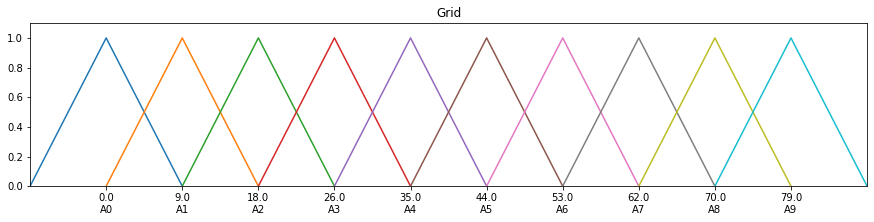

In [274]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y2 = datasets1['SpeedActual']
tam_grupo = 100
i=0
VU2=[]
V2=[]

for i in range(0,y2.size,tam_grupo):
  grpan = y2[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model2 = metodo(partitioner=part, progress=False, type='distribution')
    if model2.is_high_order:
      model2 = metodo(partitioner=part, order=1)
    model2.fit(np.asarray(y2))  
  #print(model1)
  _, _, lhs2, rhs2 = pwfts.highorder_fuzzy_markov_chain(model2)
  lhs2t = np.transpose(lhs2)
  V2 = np.c_[rhs2,lhs2t]
  if i == 0 :
    VU2 = V2
  else:
    VU2 = np.c_[VU2,V2]

  print(i)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,3])  
part.plot(ax)
VU2 = np.transpose(VU2)
print(VU2)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
[[9.33483646e-01 1.35683348e-01 2.23047541e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.83234688e-02 2.38715771e-01 1.31618467e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.22660326e-02 4.78170863e-01 4.86623094e-01 ... 2.33813611e-03
  2.46540407e-04 6.29473001e-04]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.45455029e-01
  4.37907694e-01 3.27075385e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.92517975e-03
  4.06890438e-01 6.57699285e-01]
 [7.08175799e-02 4.40861102e-02 8.58312624e-02 ... 6.90609954e-02
  7.45735152e-02 9.08793908e-02]]


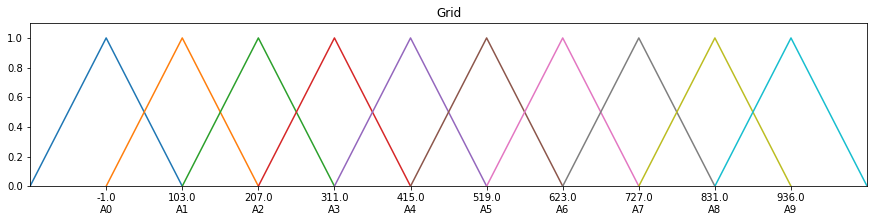

In [275]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y3 = datasets1['BeltLoad']
tam_grupo = 100
i=0
VU3=[]
V3=[]

for i in range(0,y3.size,tam_grupo):
  grpan = y3[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model3 = metodo(partitioner=part, progress=False, type='distribution')
    if model3.is_high_order:
      model3 = metodo(partitioner=part, order=1)
    model3.fit(np.asarray(y3))  
  #print(model1)
  _, _, lhs3, rhs3 = pwfts.highorder_fuzzy_markov_chain(model3)
  lhs3t = np.transpose(lhs3)
  V3 = np.c_[rhs3,lhs3t]
  if i == 0 :
    VU3 = V3
  else:
    VU3 = np.c_[VU3,V3]

  print(i)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,3])  
part.plot(ax)
VU3 = np.transpose(VU3)
print(VU3)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
[[9.20277113e-01 1.63243385e-01 7.72177653e-02 ... 0.00000000e+00
  4.96964525e-03 1.18451212e-03]
 [4.14654070e-02 2.44976791e-01 1.31073640e-01 ... 1.22462384e-03
  0.00000000e+00 6.01542635e-04]
 [1.98005827e-02 3.85069054e-01 4.54367197e-01 ... 2.65859646e-03
  7.27643740e-03 8.19536248e-04]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.93336936e-01
  4.20767073e-01 2.07500635e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.28810930e-02
  3.51146216e-01 7.75837176e-01]
 [1.64589424e-01 5.34998365e-02 8.08454108e-02 ... 6.27747192e-02
  5.89876532e-02 9.72880672e-02]]


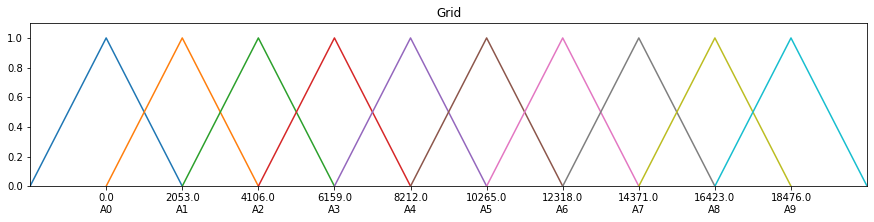

In [276]:
#Dados Com Falhas
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 10
y4 = datasets1['Rate']
tam_grupo = 100
i=0
VU4=[]
V4=[]

for i in range(0,y4.size,tam_grupo):
  grpan = y4[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model4 = metodo(partitioner=part, progress=False, type='distribution')
    if model4.is_high_order:
      model4 = metodo(partitioner=part, order=1)
    model4.fit(np.asarray(y4))  
  #print(model1)
  _, _, lhs4, rhs4 = pwfts.highorder_fuzzy_markov_chain(model4)
  lhs4t = np.transpose(lhs4)
  V4 = np.c_[rhs4,lhs4t]
  if i == 0 :
    VU4 = V4
  else:
    VU4 = np.c_[VU4,V4]

  print(i)
  
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,3])  
part.plot(ax)
VU4 = np.transpose(VU4)
print(VU4)

In [277]:
ytst1 = np.ones(198)
ytst2 = np.zeros(253)
ytst = np.concatenate((ytst1,ytst2))

In [278]:
#Unir todas as matrizes geradas
BaseT1 = np.transpose(np.concatenate([np.transpose(VT1),np.transpose(VT2),np.transpose(VT3),np.transpose(VT4)]))
BaseT2 = np.transpose(np.concatenate([np.transpose(VU1),np.transpose(VU2),np.transpose(VU3),np.transpose(VU4)]))
BaseT3 = np.c_[np.transpose(BaseT1), np.transpose(BaseT2)]
BaseT4 = np.c_[np.transpose(BaseT3),ytst]

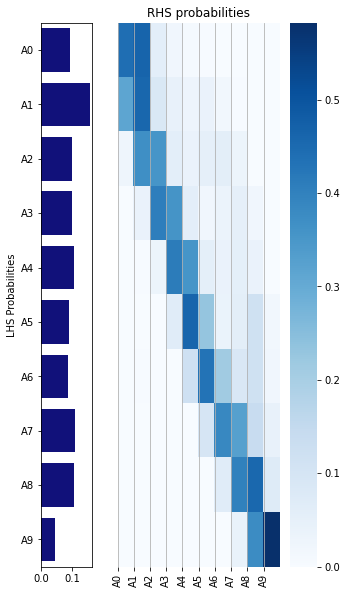

In [279]:
pwfts.visualize_distributions(model1)

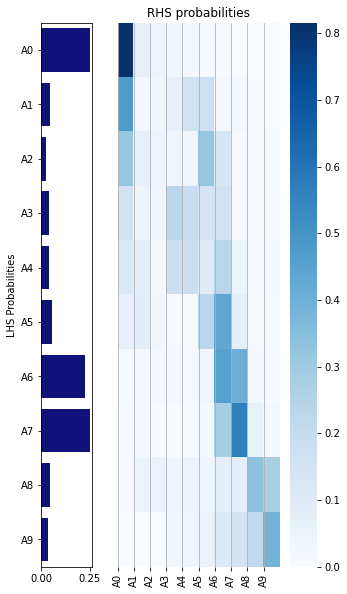

In [280]:
pwfts.visualize_distributions(model2)

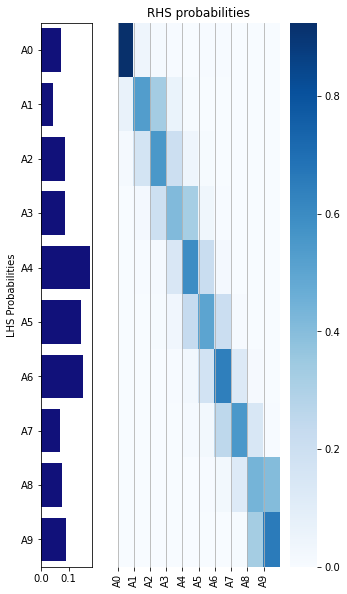

In [281]:
pwfts.visualize_distributions(model3)

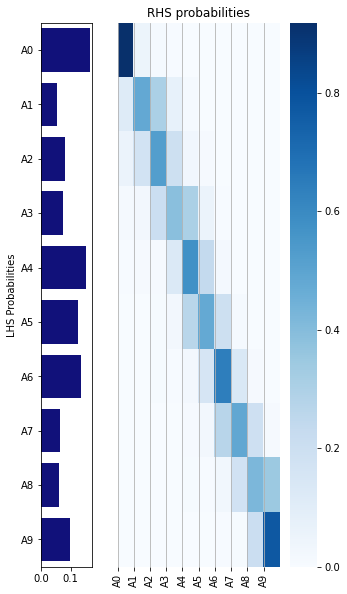

In [282]:
pwfts.visualize_distributions(model4)

In [283]:
#dataset = pd.read_excel('../content/sample_data/Base.xlsx')
#x = dataset.iloc[:,:-1].values
#y = dataset.iloc[:,-1].values
x = BaseT4[:,:-1]
y = BaseT4[:,-1]

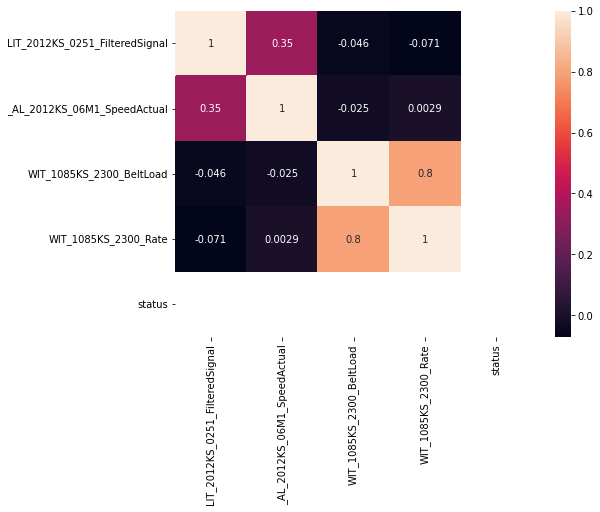

In [284]:
import seaborn as sns
#dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dff.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

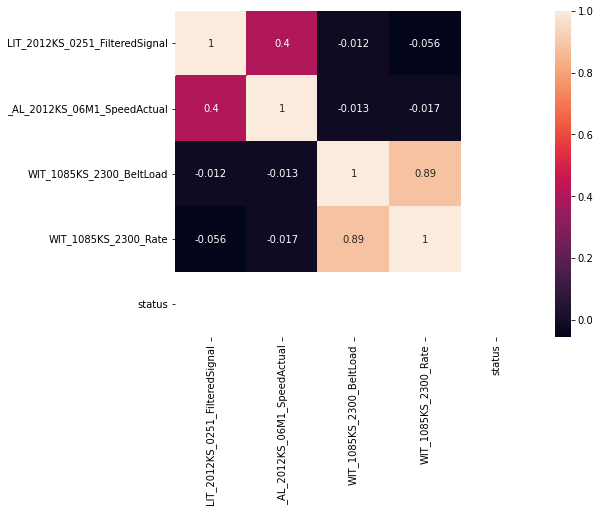

In [285]:
import seaborn as sns
#dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dfn.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

In [286]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x , y, test_size = 0.2, random_state = 10)

In [287]:
from xgboost import XGBClassifier
Classifier = XGBClassifier()
Classifier.fit(x_train, y_train)

XGBClassifier()

Matriz de confusão

In [288]:
from sklearn.metrics import confusion_matrix, accuracy_score
ypred = Classifier.predict(x_test)
cm = confusion_matrix(y_test, ypred)
print(cm)

[[47  0]
 [ 1 43]]


#Precisão

In [289]:
accuracy_score(y_test, ypred)

0.989010989010989

In [290]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Classifier, X = x_train, y = y_train, cv = 2)

print(accuracies.mean()*100)
print(accuracies.std()*100)

93.88888888888889
1.6666666666666663


##Predição com Classificação

In [291]:
#Impórtando os novos arquivos para realizar a classificação dos mesmos, porem com horizonte predito. Representando predição
#1- Importar arquivos
#2- Realizar predição a 100 e a 200 passos a frente(Intervalos de tempo aceitáveis)
#3- Obter pesos e regras da PWFTS
#4- Aplicar no Classificador já treinado anteriormente.

dPredicaoNormal = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/PrevNormal.xlsx')
dPredicaoFalha = pd.read_excel('../content/drive/MyDrive/DadosPWFTS/PrevFalha.xlsx')

N200passos = 200
N100passos = 100

#func = [Membership.trimf, Membership.trapmf, Membership.gaussmf]

In [292]:
#Dados normais - sem falhas
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets5 = {}

datasets5['LIT'] = dPredicaoNormal.get('LIT')
datasets5['SpeedActual'] = dPredicaoNormal.get('SpeedActual')
datasets5['BeltLoad'] = dPredicaoNormal.get('BeltLoad')
datasets5['Rate'] = dPredicaoNormal.get('Rate')
datasets5['Status'] = dPredicaoNormal.get('Status')


,Partitions,RMSE,MAPE,U
0,Grid,8.16,88.66,3.56


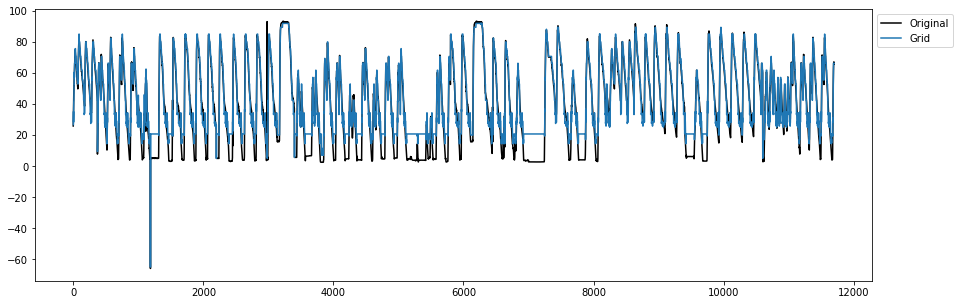

In [314]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy
from pyFTS.benchmarks import Measures

metodos = [Grid.GridPartitioner]#, Entropy.EntropyPartitioner, CMeans.CMeansPartitioner ]

k = 35

rows = []

y11=np.asarray(datasets5['LIT'])
y11n = y11
y11=y11[:-100]
y11train = y11[:7000]
y11test = y11[7000:]

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y11, label='Original',color='black')

for contador, metodo in enumerate(metodos):
  part11 = metodo(data=y11, npart=k)
  model11 = hofts.HighOrderFTS(order=2, partitioner=part11)
  model11.fit(y11train)
  forecasts11 = model11.predict(y11)
  for o in range(model11.order):
    forecasts11.insert(0,None)
    
  ax.plot(forecasts11[:-1], label=part11.name)
  
  rmse, mape, u = Measures.get_point_statistics(y11, model11)
  
  rows.append([part11.name, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

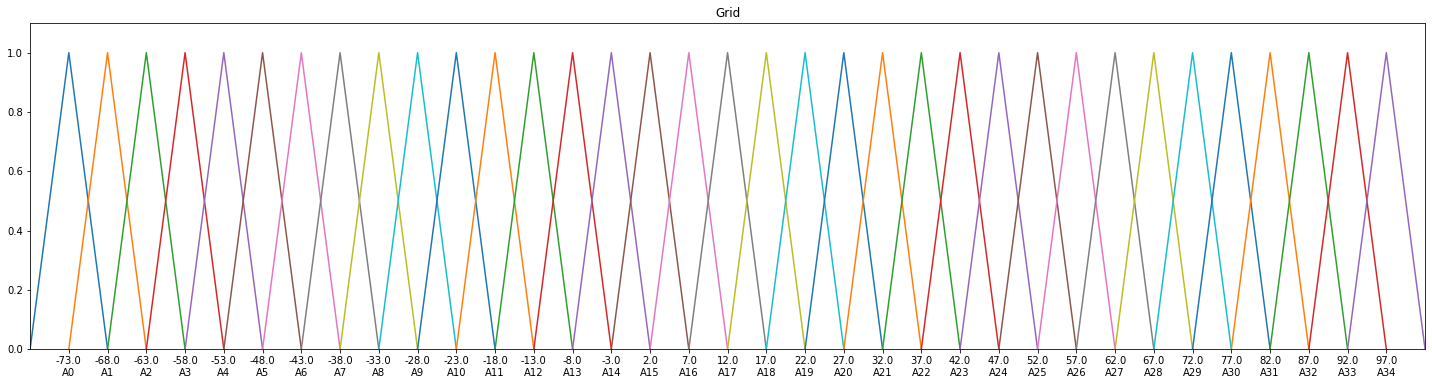

In [294]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[25,6])  
part11.plot(ax)

,Partitions,RMSE,MAPE,U
0,Grid,13.83,inf,3.39


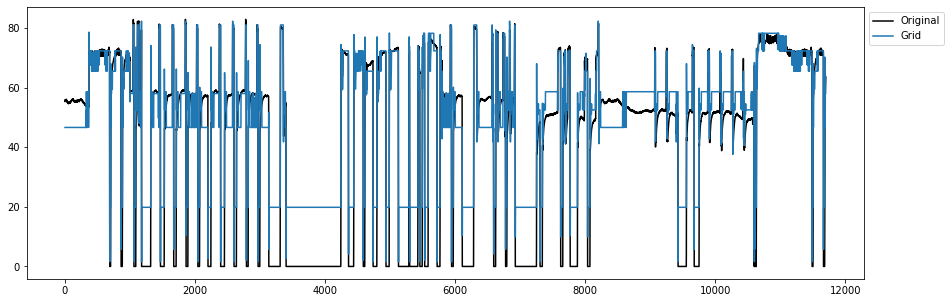

In [315]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy
from pyFTS.benchmarks import Measures

metodos = [Grid.GridPartitioner]#, Entropy.EntropyPartitioner, CMeans.CMeansPartitioner ]

k = 35

rows = []

y22=np.asarray(datasets5['SpeedActual'])
y22n = y22
y22=y22[:-100]
y22train = y22[:7000]
y22test = y22[7000:]

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y22, label='Original',color='black')

for contador, metodo in enumerate(metodos):
  part22 = metodo(data=y22, npart=k)
  model22 = hofts.HighOrderFTS(order=2, partitioner=part22)
  model22.fit(y22train)
  forecasts22 = model.predict(y22)
  for o in range(model22.order):
    forecasts22.insert(0,None)
    
  ax.plot(forecasts22[:-1], label=part22.name)
  
  rmse, mape, u = Measures.get_point_statistics(y22, model22)
  
  rows.append([part22.name, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

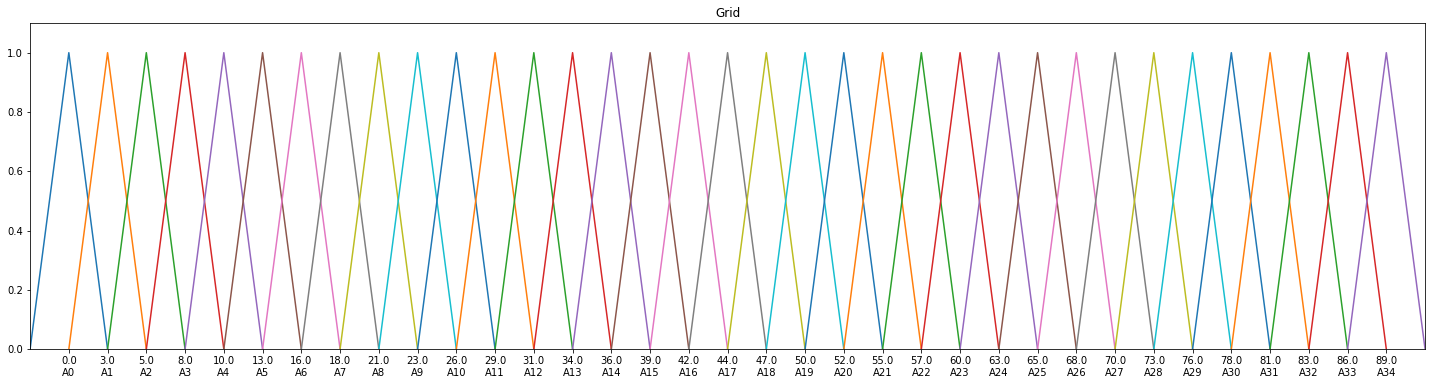

In [296]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[25,6])  
part22.plot(ax)

,Partitions,RMSE,MAPE,U
0,Grid,76.47,inf,0.92


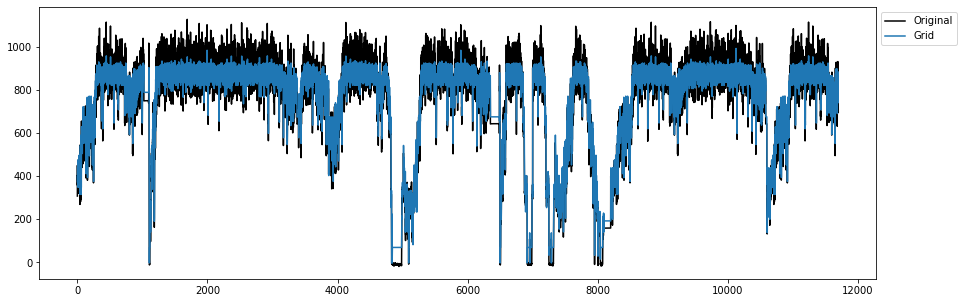

In [313]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy
from pyFTS.benchmarks import Measures

metodos = [Grid.GridPartitioner]#, Entropy.EntropyPartitioner, CMeans.CMeansPartitioner ]

k = 35

rows = []

y33=np.asarray(datasets5['BeltLoad'])
y33n = y33
y33=y33[:-100]
y33train = y33[:7000]
y33test = y33[7000:]

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y33, label='Original',color='black')

for contador, metodo in enumerate(metodos):
  part33 = metodo(data=y33, npart=k)
  model33 = hofts.HighOrderFTS(order=2, partitioner=part33)
  model33.fit(y33train)
  forecasts33 = model33.predict(y33)
  for o in range(model33.order):
    forecasts33.insert(0,None)
    
  ax.plot(forecasts33[:-1], label=part33.name)
  
  rmse, mape, u = Measures.get_point_statistics(y33, model33)
  
  rows.append([part33.name, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

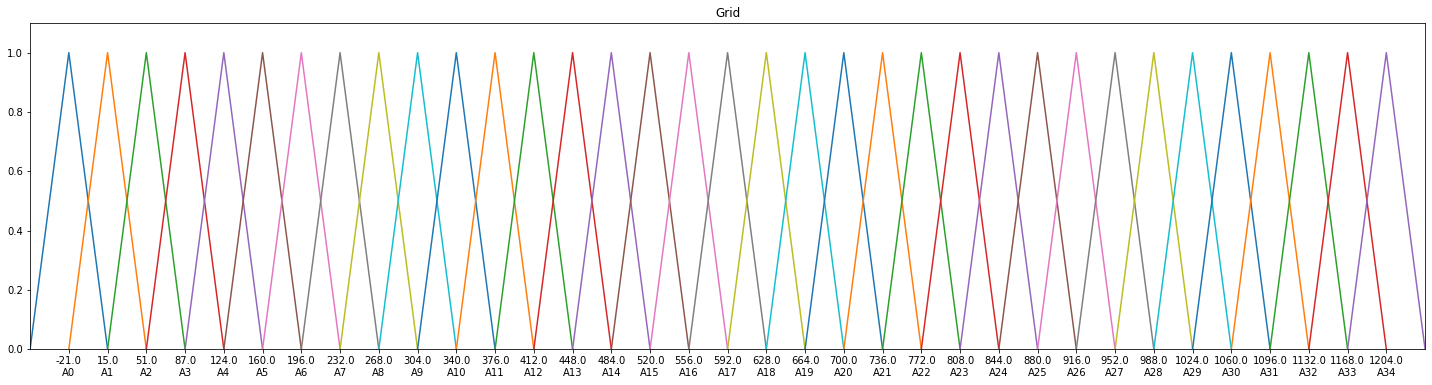

In [298]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[25,6])  
part33.plot(ax)

,Partitions,RMSE,MAPE,U
0,Grid,1877.76,inf,1.08


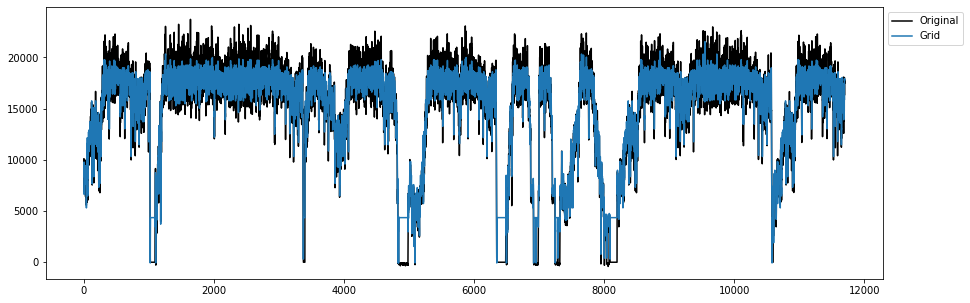

In [312]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy
from pyFTS.benchmarks import Measures

metodos = [Grid.GridPartitioner]#, Entropy.EntropyPartitioner, CMeans.CMeansPartitioner ]

k = 35

rows = []

y44=np.asarray(datasets5['Rate'])
y44n = y44
y44=y44[:-100]
y44train = y44[:7000]
y44test = y44[7000:]

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y44, label='Original',color='black')

for contador, metodo in enumerate(metodos):
  part44 = metodo(data=y44, npart=k)
  model44 = hofts.HighOrderFTS(order=2, partitioner=part44)
  model44.fit(y44train)
  forecasts44 = model44.predict(y44)
  for o in range(model44.order):
    forecasts44.insert(0,None)
    
  ax.plot(forecasts44[:-1], label=part44.name)
  
  rmse, mape, u = Measures.get_point_statistics(y44, model44)
  
  rows.append([part44.name, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

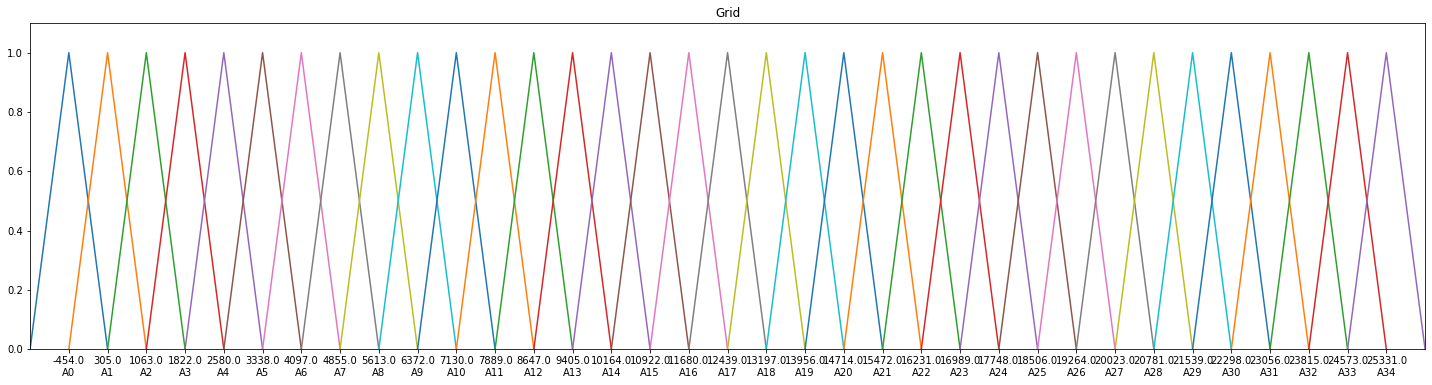

In [300]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[25,6])  
part44.plot(ax)

####Predicoes

In [316]:
#Realizando predições de 100 passos a frente dos modelos treinados - 100 passos
PredictLIT = model11.predict(np.array(y11test),type='point', method='heuristic', steps_ahead=100)
PredictSpeedActual = model22.predict(np.array(y22test),type='point', method='heuristic', steps_ahead=100)
PredictBeltLoad = model33.predict(np.array(y33test),type='point', method='heuristic', steps_ahead=100)
PredictRate = model44.predict(np.array(y44test),type='point', method='heuristic', steps_ahead=100)

In [317]:
#Obtendo o novo modelo com os dados preditos
model11Predict = pwfts.ProbabilisticWeightedFTS(order=2, partitioner=part11, progress=False, type='distribution')
DadosPredTestV1 = np.concatenate([y11,np.asarray(PredictLIT)])#Junção dados treino e dados preditos
model11Predict.fit(DadosPredTestV1)#adicionar dados de  teste
#Obtendo o novo modelo com os dados preditos
model22Predict = pwfts.ProbabilisticWeightedFTS(order=2, partitioner=part22, progress=False, type='distribution')
DadosPredTestV2 = np.concatenate([y22,np.asarray(PredictSpeedActual)])#Junção dados treino e dados preditos
model22Predict.fit(DadosPredTestV2)#adicionar dados de  teste
#Obtendo o novo modelo com os dados preditos
model33Predict = pwfts.ProbabilisticWeightedFTS(order=2, partitioner=part33, progress=False, type='distribution')
DadosPredTestV3 = np.concatenate([y33,np.asarray(PredictBeltLoad)])#Junção dados treino e dados preditos
model33Predict.fit(DadosPredTestV3)#adicionar dados de  teste
#Obtendo o novo modelo com os dados preditos
model44Predict = pwfts.ProbabilisticWeightedFTS(order=2, partitioner=part44, progress=False, type='distribution')
DadosPredTestV4 = np.concatenate([y44,np.asarray(PredictRate)])#Junção dados treino e dados preditos
model44Predict.fit(DadosPredTestV4)#adicionar dados de  teste

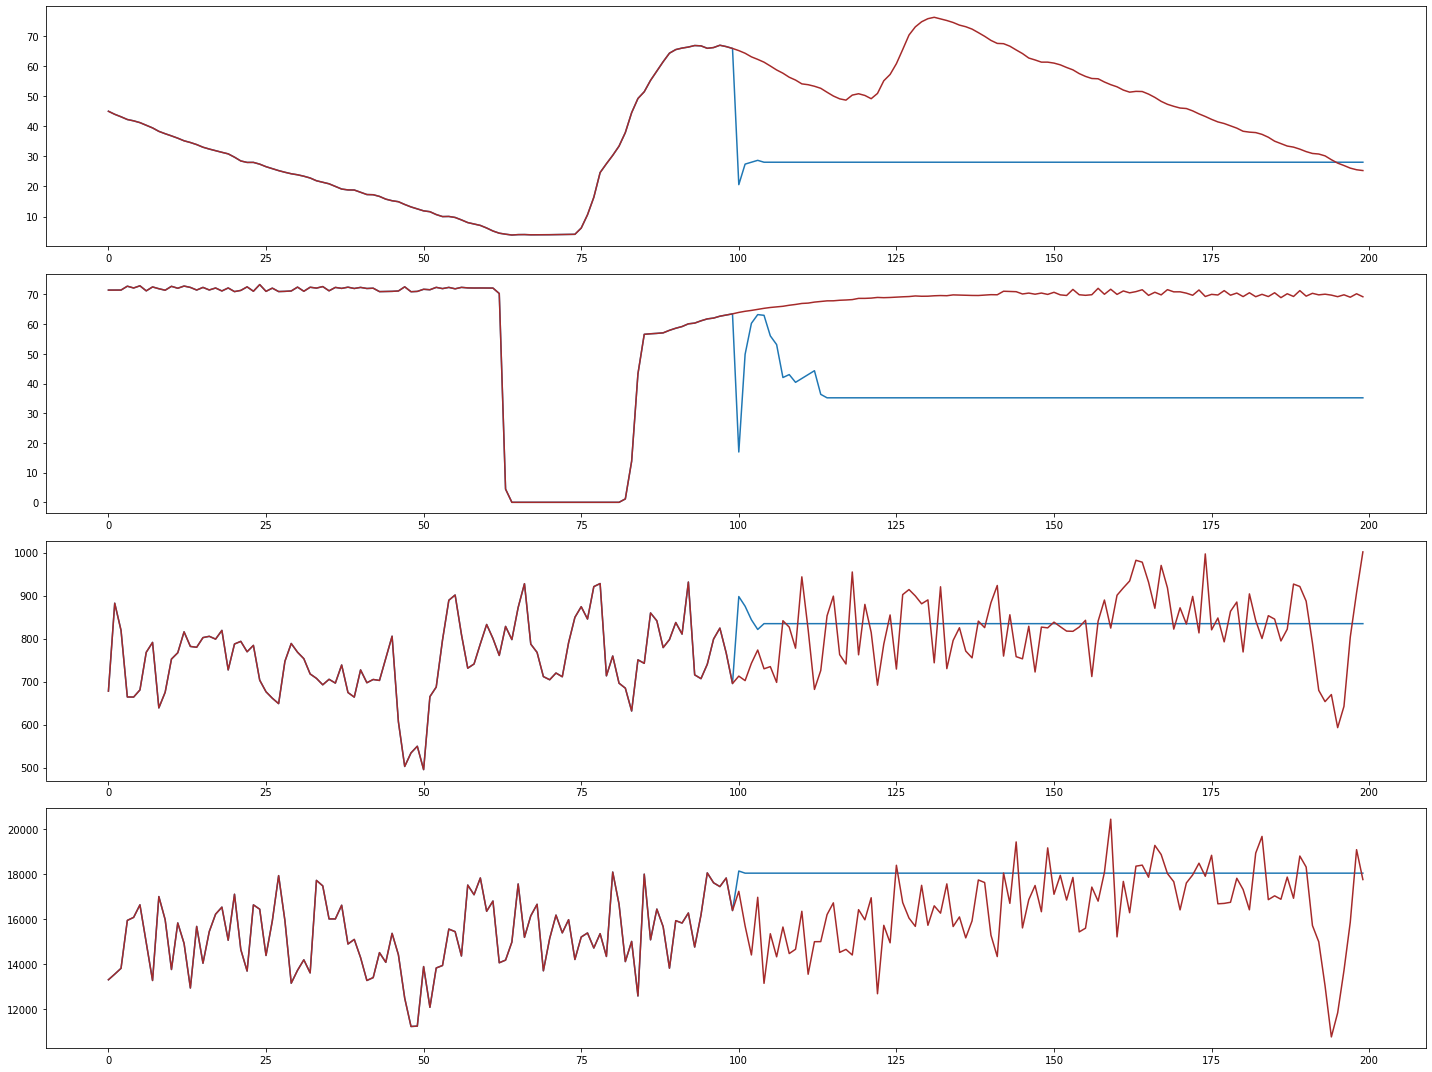

In [319]:
fig8, ax = plt.subplots(nrows=4, ncols=1, figsize=[20,15])

ax[0].plot(DadosPredTestV1[-200:])
ax[0].plot(np.asarray(datasets5['LIT'])[-200:],color='brown')
ax[1].plot(DadosPredTestV2[-200:])
ax[1].plot(np.asarray(datasets5['SpeedActual'])[-200:],color='brown')
ax[2].plot(DadosPredTestV3[-200:])
ax[2].plot(np.asarray(datasets5['BeltLoad'])[-200:],color='brown')
ax[3].plot(DadosPredTestV4[-200:])
ax[3].plot(np.asarray(datasets5['Rate'])[-200:],color='brown')

plt.tight_layout()

In [ ]:
_, _, lhs11p, rhs11p = pwfts.highorder_fuzzy_markov_chain(model11Predict)
#print(lhs11p)
#print(rhs11p)
_, _, lhs22p, rhs22p = pwfts.highorder_fuzzy_markov_chain(model22Predict)
#print(lhs22p)
#print(rhs22p)
_, _, lhs33p, rhs33p = pwfts.highorder_fuzzy_markov_chain(model33Predict)
#print(lhs33p)
#print(rhs33p)
_, _, lhs44p, rhs44p = pwfts.highorder_fuzzy_markov_chain(model44Predict)
#print(lhs44p)
#print(rhs44p)

lhs11pt = np.transpose(lhs11p)
V1_Markov = np.c_[rhs11p,lhs11pt]

lhs22pt = np.transpose(lhs22p)
V2_Markov = np.c_[rhs22p,lhs22pt]

lhs33pt = np.transpose(lhs33p)
V3_Markov = np.c_[rhs33p,lhs33pt]

lhs44pt = np.transpose(lhs44p)
V4_Markov = np.c_[rhs44p,lhs44pt]

In [ ]:
ytst11 = np.ones(15)
ytst22 = np.zeros(14)
#ytstt = np.concatenate((ytst11,ytst22))
#ytstt = ytst11

In [ ]:
print(ytst11)

In [ ]:
BaseTT1 = np.transpose(np.concatenate([np.transpose(V1_Markov[:144]),np.transpose(V2_Markov[:144]),np.transpose(V3_Markov[:144]),np.transpose(V4_Markov[:144])]))

In [ ]:
print(BaseTT1)

In [ ]:
BaseT4 = np.c_[np.transpose(BaseTT1),ytstt]

In [ ]:
#dataset
x = BaseT4[:,:-1]
y = BaseT4[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x , y, test_size = 0.2, random_state = 10)

In [ ]:
from xgboost import XGBClassifier
Classifier = XGBClassifier()
Classifier.fit(x_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
ypred = Classifier.predict(x_test)
cm = confusion_matrix(ytstt, ypred)
print(cm)

In [ ]:
accuracy_score(ytstt, ypred)

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Classifier, X = x_train, y = y_train, cv = 2)

print(accuracies.mean()*100)
print(accuracies.std()*100)

####MVFTS

In [ ]:
from pyFTS.models.multivariate import wmvfts, granular




train = datasets5.iloc[:15000]
test = datasets5.iloc[:24505]

datasets5.head()


model1_mvfts = wmvfts.WeightedMVFTS(explanatory_variables=[y11, y22, y33, y44], target_variable=y11)
model2_mvfts = granular.GranularWMVFTS(explanatory_variables=[y11, y22, y33, y44], target_variable=y11, order=2, knn=2)

rows = []

for ct, model in enumerate([model1_mvfts, model2_mvfts]):
  
  model.fit(train)
  
  forecasts = model.predict(test.iloc[:100])
  if model.is_high_order:
    for k in range(model.order):
      forecasts.insert(0,None)
  ax.plot(forecasts[:100], label=model.shortname)
  rmse, mape, u = Measures.get_point_statistics(test, model)
  
  rows.append([model.name, rmse, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Model','RMSE','U'])


####Tentativa 2

In [ ]:
#Tratando os dados de nível
#Dados Com Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 45#testar com 5000 dados e testar ordem 3
y1 = datasets5['LIT']
tam_grupo = 100 #N100passos
#tam_grupo = N100passos
i=3200
FoN = 0
#Validar variáveis
VU1=[]
V1_Markov =[]
V1T=[]
Bv1=[]
DataFit = y1[:3200]

for i in range(0,y1.size,tam_grupo):
  print(i)
  grpan = y1[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model1 = metodo(partitioner=part, progress=False, type='distribution')
    if model1.is_high_order:
      model1 = metodo(partitioner=part, order=3)
    model1.fit(np.asarray(DataFit))
    #print(model1)  
    #Predicao
    PredictLIT = model1.predict(np.array(grpan),type='point', method='heuristic', steps_ahead=tam_grupo)
    PredV1 = PredictLIT
    #PredV1T = pd.concat(np.transpose(y1),PredV1)
    print(PredV1)#Vizualização dos valores previstos da variavael 1
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
    ax.plot(np.array(grpan[:100]))
    ax.plot(PredV1[:100])
    #Com valores previstos Treinar novo Modelo
    partPred = Grid.GridPartitioner(data=np.asarray(PredV1), npart=k)
    model11 = pwfts.ProbabilisticWeightedFTS(partitioner=part, progress=False, type='distribution')
    model11.fit(np.asarray(PredV1))#Treinando novo modelo com os valores previstos 
    #print(model11)
  #Obtenção modelo de regras PWFTS
  _, _, lhs11, rhs11 = pwfts.highorder_fuzzy_markov_chain(model11)
  FoN=sum(grpan)
  #print(lhs11)
  #print(rhs11)
  lhs11t = np.transpose(lhs11)
  V1_Markov = np.c_[rhs11,lhs11t]
  print(i)
print(V1_Markov)

In [ ]:
#Tratando os dados de nível
#Dados Com Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 45
y2 = datasets5['SpeedActual']
tam_grupo = 3000 #N100passos
#tam_grupo = N100passos
i=0
FoN = 0
#Validar variáveis
VU2=[]
V2_Markov =[]
V2T=[]

for i in range(0,y2.size,tam_grupo):
  grpan = y2[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model2 = metodo(partitioner=part, progress=False, type='distribution')
    if model2.is_high_order:
      model2 = metodo(partitioner=part, order=3)
    model2.fit(np.asarray(y2)) 
    print(model2) 
    #Predicao
    PredictSpeed = model2.predict(np.array(grpan),type='point', method='heuristic', steps_ahead=tam_grupo)
    PredV2 = PredictSpeed
    print(PredV2)#Vizualização dos valores previstos da variavael 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
    ax.plot(np.array(grpan[:100]))
    ax.plot(PredV2[:100])
    #Com valores previstos Treinar novo Modelo
    partPred = Grid.GridPartitioner(data=np.asarray(PredV2), npart=k)
    model22 = pwfts.ProbabilisticWeightedFTS(partitioner=part, progress=False, type='distribution')
    model22.fit(np.asarray(PredV2))#Treinando novo modelo com os valores previstos 
    print(model22)
  #Obtenção modelo de regras PWFTS
  _, _, lhs22, rhs22 = pwfts.highorder_fuzzy_markov_chain(model22)

  FoN=sum(grpan)
  lhs22t = np.transpose(lhs22)
  V2_Markov = np.c_[rhs22,lhs22t]
  print(i)
print(V2_Markov)

In [ ]:
#Tratando os dados de nível
#Dados Com Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 45
y3 = datasets5['BeltLoad']
tam_grupo = 3000 #N100passos
#tam_grupo = N100passos
i=0

#Validar variáveis
VU3=[]
V3_Markov =[]
V3T=[]

for i in range(0,y3.size,tam_grupo):
  grpan = y3[i:i+tam_grupo]#1000 amostras
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model3 = metodo(partitioner=part, progress=False, type='distribution')
    if model3.is_high_order:
      model3 = metodo(partitioner=part, order=3)
    model3.fit(np.asarray(grpan))
    print(model3)  
    #Predicao
    PredictBelt = model3.predict(np.array(grpan), type='point', method='heuristic', steps_ahead=tam_grupo)    
    PredV3 = PredictBelt
    print(PredV3)#Vizualização dos valores previstos da variavael 2
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
    ax.plot(np.array(grpan[:100]))
    ax.plot(PredV3[:100])
    #Com valores previstos Treinar novo Modelo
    partPred = Grid.GridPartitioner(data=np.asarray(PredV3), npart=k)
    model33 = pwfts.ProbabilisticWeightedFTS(partitioner=part, progress=False, type='distribution')
    model33.fit(np.asarray(PredV3))#Treinando novo modelo com os valores previstos 
    print(model33)
    
  #Obtenção modelo de regras PWFTS
  _, _, lhs33, rhs33 = pwfts.highorder_fuzzy_markov_chain(model33)#Obtenção dos Pesos
  _, _, lhs3, rhs3 = pwfts.highorder_fuzzy_markov_chain(model3)#Obtenção dos Pesos

  FoN=sum(grpan)
  lhs33t = np.transpose(lhs33)
  V3_Markov = np.c_[rhs33,lhs33t]
  print(i)
print(V3_Markov)

In [ ]:
#Tratando os dados de nível
#Dados Com Falhas
from numpy.core.multiarray import concatenate
from pyFTS.models import pwfts
#from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
from pyFTS.common import Util

#metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
#          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]
metodos = [pwfts.ProbabilisticWeightedFTS]

k = 45
y4 = datasets5['Rate']
tam_grupo = 3000 #N100passos
#tam_grupo = N100passos
i=0
FoN = 0 
#Validar variáveis
VU4=[]
V4_Markov =[]
V4T=[]

for i in range(0,y4.size,tam_grupo):
  grpan = y4[i:i+tam_grupo]
  part = Grid.GridPartitioner(data=np.asarray(grpan), npart=k)
  for contador, metodo in enumerate(metodos):
    model4 = metodo(partitioner=part, progress=False, type='distribution')
    if model4.is_high_order:
      model4 = metodo(partitioner=part, order=3)
    model4.fit(np.asarray(grpan))  
    #Predicao
    PredictRate = model4.predict(np.array(grpan),type='point', method='heuristic', steps_ahead=tam_grupo)
    PredV4 = PredictRate
    print(PredV4)#Vizualização dos valores previstos da variavael 1
    #plt.plot(PredV4)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])
    ax.plot(np.array(grpan[:100]))
    ax.plot(PredV4[:100])
      #Com valores previstos Treinar novo Modelo
    partPred = Grid.GridPartitioner(data=np.asarray(PredV4), npart=k)
    model44 = pwfts.ProbabilisticWeightedFTS(partitioner=part, progress=False, type='distribution')
    model44.fit(np.asarray(PredV4))#Treinando novo modelo com os valores previstos 
  #Obtenção modelo de regras PWFTS
  FOS, OS, lhs44, rhs44 = pwfts.highorder_fuzzy_markov_chain(model44)#Obtenção dos Pesos

  FoN=sum(grpan)
  lhs44t = np.transpose(lhs44)
  V4_Markov = np.c_[rhs44,lhs44t]
  print(i)
print(V4_Markov)

In [ ]:
ytst11 = np.ones(60)
ytst22 = np.zeros(0)
ytstt = np.concatenate((ytst11,ytst22))

In [ ]:
BaseTT1 = np.transpose(np.concatenate([np.transpose(V1_Markov),np.transpose(V2_Markov),np.transpose(V3_Markov),np.transpose(V4_Markov)]))
BaseT4 = np.c_[np.transpose(BaseTT1),ytstt]

In [ ]:
  from sklearn.metrics import confusion_matrix, accuracy_score
  ypred = Classifier.predict(x)
  cm = confusion_matrix(y, ypred)
  print(cm)